## **Cleaning Data** 

## Import libraries

In [24]:
import numpy as np
import seaborn as sns
import pandas as pd 
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import pandas as pd
from pyspark import SparkContext, SparkConf


# Read dataset

In [18]:
music = pd.read_csv("music_genre_dataset.csv")
music

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.000000,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.000000,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.000000,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.000000,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.000000,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15512,Television,Marquee Moon - Remastered,47.0,0.494,0.657,7.0,-7.543,1,0.0397,0.063200,0.449000,0.0849,0.7370,118.194,645000.000000,4,1
15513,Hulkoff,Martialisk - Svitjod Edition,39.0,0.487,0.984,1.0,-4.790,1,0.1610,0.000439,0.023400,0.3540,0.2910,120.031,225627.000000,4,8
15514,"Red Garland, Paul Chambers, Art Taylor",Almost Like Being In Love,57.0,0.561,0.346,NaN,-12.596,0,0.0409,0.873000,0.399000,0.1040,0.6970,93.689,4.838217,4,7
15515,Squid,Sludge,41.0,0.391,0.835,7.0,-4.944,1,0.0702,0.004850,0.005140,0.1180,0.1090,129.024,300820.000000,4,6


# Type of attributes 

In [4]:
music.dtypes


Artist Name            object
Track Name             object
Popularity            float64
danceability          float64
energy                float64
key                   float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_in min/ms    float64
time_signature          int64
Class                   int64
dtype: object

# missing percentage  per attribute 

In [5]:
missing_values = music.isna().sum()/len(music)*100
missing_values

Artist Name            0.000000
Track Name             0.000000
Popularity             2.539151
danceability           0.000000
energy                 0.000000
key                   11.232841
loudness               0.000000
mode                   0.000000
speechiness            0.000000
acousticness           0.000000
instrumentalness      23.116582
liveness               0.000000
valence                0.000000
tempo                  0.000000
duration_in min/ms     0.000000
time_signature         0.000000
Class                  0.000000
dtype: float64

In [6]:
music.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,15123.000000,15517.000000,15517.000000,13774.000000,15517.000000,15517.000000,15517.000000,15517.000000,11930.000000,15517.000000,15517.000000,15517.000000,1.551700e+04,15517.000000,15517.000000
mean,45.582358,0.541469,0.668711,5.964281,-7.856428,0.652639,0.080936,0.238502,0.177348,0.196837,0.487344,122.833548,1.992960e+05,3.925114,6.564155
std,17.400843,0.166838,0.235402,3.196333,4.018688,0.476147,0.084977,0.309605,0.302935,0.160212,0.240228,29.686429,1.148326e+05,0.360904,3.258829
min,1.000000,0.059600,0.001210,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.021500,30.557000,5.016500e-01,1.000000,0.000000
25%,34.000000,0.430000,0.517000,3.000000,-9.483000,0.000000,0.035100,0.003380,0.000097,0.097400,0.298000,99.729000,1.632400e+05,4.000000,5.000000
50%,45.000000,0.543000,0.708000,6.000000,-6.971000,1.000000,0.048300,0.068100,0.004215,0.129000,0.484000,120.065000,2.084270e+05,4.000000,8.000000
75%,57.000000,0.656000,0.866000,9.000000,-5.150000,1.000000,0.084800,0.410000,0.203000,0.260000,0.674000,142.378000,2.522530e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


## Handling missing  values in Popularity by drop rows since it's small percentage that missing

In [7]:
music=music.dropna(subset=['Popularity'])


In [8]:
missing_values = music.isna().sum()/len(music)*100
missing_values

Artist Name            0.000000
Track Name             0.000000
Popularity             0.000000
danceability           0.000000
energy                 0.000000
key                   11.175031
loudness               0.000000
mode                   0.000000
speechiness            0.000000
acousticness           0.000000
instrumentalness      23.004695
liveness               0.000000
valence                0.000000
tempo                  0.000000
duration_in min/ms     0.000000
time_signature         0.000000
Class                  0.000000
dtype: float64

# Handling missing values in key and  instrumentalness 

In [9]:
#key 




imp = IterativeImputer(missing_values=np.nan,
                       max_iter=20,tol=0.001)
imp.fit(music[['key']])
music['key'] = data=imp.transform(music[['key']]).ravel()


# instrumentalness 

imp = IterativeImputer(missing_values=np.nan,
                       max_iter=20,tol=0.001)
imp.fit(music[['instrumentalness']])
music['instrumentalness'] = data=imp.transform(music[['instrumentalness']]).ravel()




C:\Users\HP\AppData\Local\Temp\ipykernel_24532\583266822.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music['key'] = data=imp.transform(music[['key']]).ravel()
C:\Users\HP\AppData\Local\Temp\ipykernel_24532\583266822.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music['instrumentalness'] = data=imp.transform(music[['instrumentalness']]).ravel()


In [10]:
missing_values = music.isna().sum()/len(music)*100
missing_values

Artist Name           0.0
Track Name            0.0
Popularity            0.0
danceability          0.0
energy                0.0
key                   0.0
loudness              0.0
mode                  0.0
speechiness           0.0
acousticness          0.0
instrumentalness      0.0
liveness              0.0
valence               0.0
tempo                 0.0
duration_in min/ms    0.0
time_signature        0.0
Class                 0.0
dtype: float64

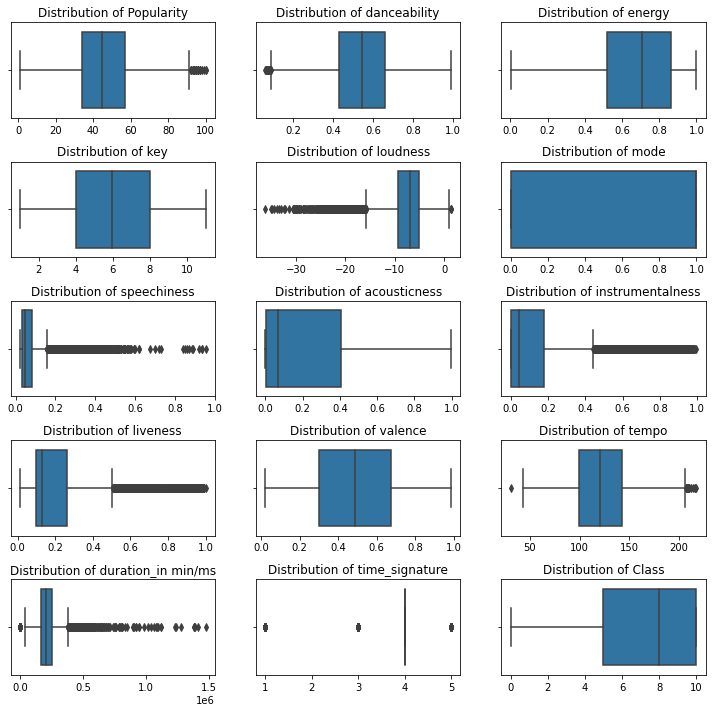

In [15]:
music_cleaned = music.select_dtypes([int, float])

fig=plt.figure(figsize=(10,10))
for i ,columns in enumerate (music_cleaned,1):
    ax= plt.subplot(5,3,i)
    sns.boxplot(data= music_cleaned , x=music_cleaned[columns])
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {columns}')
    plt.tight_layout(w_pad=3)
plt.show()



In [23]:
labels=music["Class"]
songs = music.drop(columns=["Class"], axis=1)

songs
labels.unique() 


array([ 5, 10,  6,  2,  4,  8,  3,  7,  1,  9,  0], dtype=int64)

# point 2

## **SparkSQL**

In [26]:
!pip install findspark

In [27]:
import findspark
findspark.init()

In [28]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

KeyboardInterrupt: 

In [29]:
songs= pd.read_csv('music_genre_dataset.csv')
sdf = spark.createDataFrame(songs) 

NameError: name 'spark' is not defined

In [ ]:
sdf.printSchema()


In [ ]:
sdf.createOrReplaceTempView("songs")

## Query number one 

In [ ]:
spark.sql("SELECT ArtistName FROM songs where max(danceability) ")

## Query number two

## Query number three

## **Visualization**

## **SparkML**